### 1.1 Entropy of an image

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [0]:
%matplotlib inline

In [0]:
plt.style.use('seaborn-whitegrid')
image_path = 'img_retina.jpg'
image = cv2.imread(image_path, 0)
image = image.astype('int')

A function to calculate entropy, according to the entropy equation

In [0]:
def calculate_entropy(image):
    H = 0
    min = image.min()
    max = image.max()
    hist = np.histogram(image.flatten(), max - min + 1)[0]
    hist = hist / float(sum(hist))
    for i in range(hist.shape[0]):
        p = hist[i]
        if p > 0:
            H += -1 * p * np.log2(p)
    return H

In [0]:
def calculate_joint_entropy(img1, img2):
    jointHist = \
        np.histogram2d(img1.flatten(), img2.flatten(), [img1.max() - img1.min() + 1, img2.max() - img2.min() + 1])[0]
    jointHist = jointHist / float(np.sum(np.sum(jointHist)))
    jointH = 0
    range1, range2 = jointHist.shape
    for i in range(range1):
        for j in range(range2):
            p = jointHist[i][j]
            if p > 0:
                jointH += - p * np.log2(p)
    return jointH


In [0]:
def calculate_mutual_information(img1, img2):
    im1H = calculate_entropy(img1)
    img2H = calculate_entropy(img2)
    jointH = calculate_joint_entropy(img1, img2)
    return im1H + img2H - jointH

In [0]:
def generate_noisy_image_entropy(image):
    size = image.shape
    noise_result = []
    noisy_image_result = []
    for A in range(0, 201, 5):
        noise = np.random.uniform(-A, A, size).astype('int')
        Hn = calculate_entropy(noise)
        Hni = calculate_entropy(np.add(image, noise))
        noise_result.append([A, Hn])
        noisy_image_result.append([A, Hni])
    return np.array(noise_result), np.array(noisy_image_result)

In [0]:
def generate_noisy_image_mutual_information(image):
    size = image.shape
    mu_result = []
    for A in range(0, 201, 5):
        I = calculate_mutual_information(image, generate_noisy_image(image, A))
        mu_result.append([A, I])
    return np.array(mu_result)

In [0]:
def generate_noisy_image(image, noise):
    size = image.shape
    noise = np.random.uniform(-noise, noise, size).astype('int')
    return image + noise

In [0]:
def KL_divergence(hist1, hist2):
    Dkl = 0
    for i in range(256):
        p = hist1[i]
        q = hist2[i]
        if p > 0 and q > 0:
            Dkl += -1 * p * np.log2(q / p)
    return Dkl

In [0]:
def fspecial_generate_1d_Gaussian(mean, val, sigma, min, max):
    result = []
    for i in range(min, max):
        result.append(val * 1 / np.sqrt(2 * np.pi * sigma) * np.exp(-1 * np.power(i - mean, 2.) / (2 * sigma * sigma)))
    return result

In [0]:
def parzan_filter(hist, sigma, BW=200):
    filtered_result = np.zeros(len(hist))
    for i in range(len(hist)):
        min = 0
        max = len(hist)
        if i - BW / 2 > 0:
            min = int(i - BW / 2)
        if i + BW / 2 + 1 < len(hist):
            max = int(i + BW / 2 + 1)
        curr_gaussian = fspecial_generate_1d_Gaussian(i, hist[i], sigma, min, max)
        filtered_result[min:max] += np.array(curr_gaussian)
    filtered_result /= sum(filtered_result)
    return filtered_result

####1.1.1 Compute the entropy of I.

In [0]:
Entropy = calculate_entropy(image)
print('The entropy for image 1 is {}'.format(Entropy))

The entropy for image 1 is 6.847117961729752


####1.1.2 Generate Plot for the entropy of: I, NA and I + NA for multiple values of A

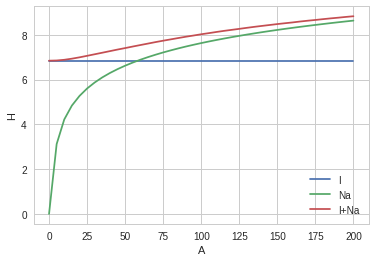

In [0]:
noise_data, image_w_noise_data = generate_noisy_image_entropy(image)
fig = plt.figure()
plt.plot(noise_data[:, 0], np.full(noise_data.shape, calculate_entropy(image))[:, 1])
plt.plot(noise_data[:, 0], noise_data[:, 1])
plt.plot(image_w_noise_data[:, 0], image_w_noise_data[:, 1])
plt.xlabel('A')
plt.ylabel('H')
plt.legend(['I', 'Na', 'I+Na'])
plt.show()
plt.close(fig)

####1.2.1 plot the mutual information between the images I and I +NA as a function of A

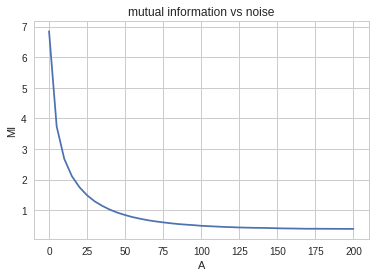

In [0]:
#Q1.2.1
mutual_info = generate_noisy_image_mutual_information(image)
fig = plt.figure()
plt.plot(mutual_info[:, 0], mutual_info[:, 1])
plt.xlabel('A')
plt.ylabel('MI')
plt.title('mutual information vs noise')
plt.show()

### 1.2.2 verify numerically H(I, I+N) = H(I) +H(I+N)-MI(I,I+N)

In [0]:
# Q1.2.2
noisyImage = generate_noisy_image(image, 20)
jointEntorpy = calculate_joint_entropy(image, noisyImage)
HI = calculate_entropy(image)
HIN = calculate_entropy(noisyImage)
mutualInfo = calculate_mutual_information(image, noisyImage)
print('H(I, I+N)-(H(I) +H(I+N)-MI(I,I+N)) = {}'.format(jointEntorpy - HI - HIN + mutualInfo))

H(I, I+N)-(H(I) +H(I+N)-MI(I,I+N)) = 0.0


#### 1.2.3 the KL divergence

In [0]:
# Q1.2.3.1
noise = np.random.uniform(0, 256, image.shape).astype('int')
noisyImage = generate_noisy_image(image, 20)
hist1 = np.histogram(image.flatten(), image.max() - image.min() + 1)[0]
hist1 = hist1 / float(sum(hist1))
hist2 = np.histogram(noise.flatten(), noise.max() - noise.min() + 1)[0]
hist2 = hist2 / float(sum(hist2))
print('the forward KL divergence of I and N is '+str(KL_divergence(hist1, hist2)))
print('the backward KL divergence of I and N is '+str(KL_divergence(hist2,hist1)))

the forward KL divergence of I and N is 1.1548575310038562
the backward KL divergence of I and N is 2.1682977048628036


####1.2.3 KL divergence between I and I+N with Parzan filter

In [0]:
# Q1.2.3.2
hist2 = np.histogram(noisyImage.flatten(), noisyImage.max() - noisyImage.min() + 1)[0]
# print(KL_divergence(hist2 / float(sum(hist2)), hist1))
hist1 = parzan_filter(hist1, 1)
hist2 = parzan_filter(hist2, 1)
print('the forward KL divergence of I and I+N is '+str(KL_divergence(hist1, hist2)))
print('the backward KL divergence of I and I+N is '+str(KL_divergence(hist2, hist1)))


the forward KL divergence of I and I+N is 0.24195182728055986
the backward KL divergence of I and I+N is 0.29027296910698386


####1.3 image registration

In [0]:
I1_1 = cv2.imread('I1_1.png', 0)
I1_2 = cv2.imread('I1_2.png', 0)
I2_1 = cv2.imread('I2_1.png', 0)
I2_2 = cv2.imread('I2_2.png', 0)

In [0]:
def mutual_information_Registration(im1, im2):
    x_bound = int(im1.shape[0] / 10)
    y_bound = int(im1.shape[1] / 10)
    max_MI = 0
    max_MI_displacement = [0, 0]
    shifted_image = np.zeros(im2.shape)
    for i in range(-y_bound, y_bound):
        for j in range(-x_bound, x_bound):
            im_update = np.zeros(im1.shape)
            a, c = 0, 0
            b, d = im1.shape
            a1, c1 = 0, 0
            b1, d1 = im1.shape
            if i < 0:
                b = im1.shape[1] + i
                a1 = -i
            elif i > 0:
                a = i
                b1 = im1.shape[1] - i
            if j < 0:
                d = im1.shape[0] + j
                c1 = -j
            elif j > 0:
                c = j
                d1 = im1.shape[0] - j
            im_update[a:b, c:d] = im1[a1:b1, c1:d1]
            # print(sum(sum(im_update)))
            MI = calculate_mutual_information(im_update.astype('int'), im2)
            if MI > max_MI:
                max_MI = MI
                max_MI_displacement = [i, j]
                shifted_image = im_update.copy()
    return max_MI_displacement,shifted_image

In [0]:

def MSE_Registration(im1, im2):
    x_bound = int(im1.shape[0] / 4)
    y_bound = int(im1.shape[1] / 4)
    minMSE = 9999999
    minMSE_displacement = [0, 0]
    shifted_image = np.zeros(im2.shape)
    for i in range(-y_bound, y_bound):
        for j in range(-x_bound, x_bound):
            im_update = np.zeros(im1.shape)
            a, c = 0, 0
            b, d = im1.shape
            a1, c1 = 0, 0
            b1, d1 = im1.shape
            if i < 0:
                b = im1.shape[1] + i
                a1 = -i
            elif i > 0:
                a = i
                b1 = im1.shape[1] - i
            if j < 0:
                d = im1.shape[0] + j
                c1 = -j
            elif j > 0:
                c = j
                d1 = im1.shape[0] - j
            im_update[a:b, c:d] = im1[a1:b1, c1:d1]
            mse = ((im_update - im2) ** 2).mean()
            if mse < minMSE:
                minMSE = mse
                minMSE_displacement = [i, j]
                shifted_image = im_update.copy()
         
    return minMSE_displacement, shifted_image

#### 1.3.1 the optimal translation for I1 1 and I1 2

I1_1, I1_2 image has a displacement of 3 to the x direction 10 to the y direction according to Mutual Information


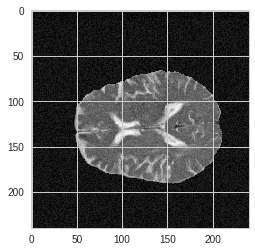

In [0]:
displacement, adjustedImage = mutual_information_Registration(I1_1.astype('int'), I1_2.astype('int'))
print('I1_1, I1_2 image has a displacement of {} to the x direction {} to the y direction according to Mutual Information'.format(displacement[1],displacement[0]))
overlayImage = cv2.addWeighted(I1_2.astype('uint8'),0.4,adjustedImage.astype('uint8'),0.1,0)
fig = plt.figure()
plt.imshow(overlayImage,cmap = 'gray')
plt.show()

I1_1, I1_2 image has a displacement of -8 to the x direction 9 to the y direction according to MSE


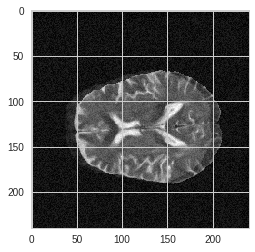

In [59]:
displacement, adjustedImage = MSE_Registration(I1_1.astype('int'), I1_2.astype('int'))
print('I1_1, I1_2 image has a displacement of {} to the x direction {} to the y direction according to MSE'.format(displacement[1],displacement[0]))
overlayImage = cv2.addWeighted(I1_2.astype('uint8'),0.4,adjustedImage.astype('uint8'),0.1,0)
fig = plt.figure()
plt.imshow(overlayImage,cmap = 'gray')
plt.show()

#### The optimal displacement for I2 1 and I2 2

In [0]:
isplacement, adjustedImage = mutual_information_Registration(I2_1.astype('int'), I2_2.astype('int'))
print('I2_1, I2_2 image has a displacement of {} according to Mutual Information'.format(displacement))


In [64]:
isplacement, adjustedImage = MSE_Registration(I2_1.astype('int'), I2_2.astype('int'))
print('I2_1, I2_2 image has a displacement of {} according to MSE'.format(displacement))


I2_1, I2_2 image has a displacement of [9, -8] according to MSE


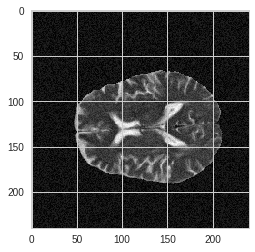

In [60]:
plt.imshow(I2_2,'gray')